# MegaMarket Dataset Analysis

This notebook provides a detailed analysis of the MegaMarket dataset, which contains data on user interactions with items on the MegaMarket marketplace over a period of 4 months. The dataset includes the following columns:

- **user_id**: Unique identifier for each user.
- **datetime**: The date and time when the interaction took place.
- **event**: Type of event (0: Click, 1: Add to cart, 2: Purchase).
- **item_id**: Unique identifier for each item.
- **category_id**: Identifier for the category to which the item belongs.
- **price**: Obfuscated price of the item.


## Importing Libraries and Files

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import defaultdict
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df = pd.read_parquet("/kaggle/input/megamarket/megamarket.parquet")
df.head(20)

/kaggle/input/megamarket/megamarket.parquet


,user_id,datetime,event,item_id,category_id,price
0,1199174,2023-02-13 03:12:19.131,2,1861088,5395,-0.042062
1,3124963,2023-02-13 09:38:55.674,2,2084441,1531,0.079817
2,2106055,2023-02-13 08:26:05.004,2,2586689,9294,-0.038990
3,4169844,2023-02-13 16:55:08.470,2,2586689,9294,-0.038990
4,7472260,2023-02-13 03:30:13.093,2,2586689,9294,-0.038990
5,7472260,2023-02-13 03:30:13.544,2,2586689,9294,-0.038990
6,2326284,2023-02-13 14:16:47.259,2,1546653,8766,-0.042370
7,7704823,2023-02-13 16:09:46.000,0,1546653,8766,-0.042370
8,7704823,2023-02-13 16:09:46.000,0,1546653,8766,-0.042370
9,7704823,2023-02-13 16:09:46.000,0,1546653,8766,-0.042370


## Data Preprocessing

In [7]:
chunk_size = 1000000

total_rows = 0
event_counts = pd.Series(dtype=int)
price_stats = []
category_counts = pd.Series(dtype=int)
user_interaction_counts = pd.Series(dtype=int)
daily_sales = defaultdict(float)
hourly_interactions = defaultdict(int)
category_event_distribution = defaultdict(lambda: defaultdict(int))

num_chunks = int(np.ceil(len(df) / chunk_size))
for i in range(num_chunks):
    chunk = df[i*chunk_size:(i+1)*chunk_size]
    
    total_rows += len(chunk)  
    
    event_counts = event_counts.add(chunk['event'].value_counts(), fill_value=0) 
    
    price_stats.append(chunk['price'].describe())  
    
    category_counts = category_counts.add(chunk['category_id'].value_counts(), fill_value=0)  
    
    user_interaction_counts = user_interaction_counts.add(chunk['user_id'].value_counts(), fill_value=0) 
    
    purchase_chunk = chunk[chunk['event'] == 2]
    for date, price in zip(purchase_chunk['datetime'], purchase_chunk['price']):
        date = date.strftime('%Y-%m-%d %H:%M:%S')
        date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        daily_sales[date.date()] += price
    
    
    for date in chunk['datetime']:
        date = date.strftime('%Y-%m-%d %H:%M:%S')
        date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        hourly_interactions[date.hour] += 1
    
     
    for category_id, event in zip(chunk['category_id'], chunk['event']):
        category_event_distribution[category_id][event] += 1

price_stats_df = pd.DataFrame(price_stats)


## Total Rows and Event Counts

In [8]:
total_rows

196644020

In [9]:
event_counts

event
0     52961163.0
1      5460762.0
2    118342938.0
3     19879157.0
dtype: float64

## Event Type Distribution

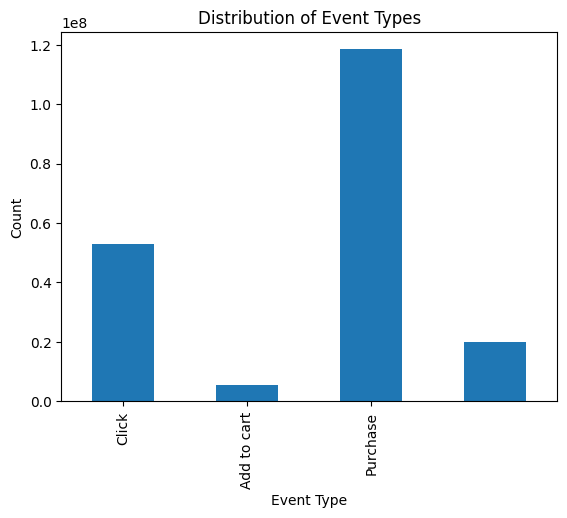

In [10]:
event_counts.plot(kind='bar')
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Click', 'Add to cart', 'Purchase'])
plt.show()

## Price Analysis

In [11]:
price_stats_df.describe()

,count,mean,std,min,25%,50%,75%,max
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000
mean,998192.994924,0.000005,0.179965,-0.042956,-0.042080,-0.037696,-0.014091,56.876290
std,25362.524855,0.013292,0.985159,0.000003,0.000403,0.002495,0.014193,701.497455
min,644020.000000,-0.030061,0.055743,-0.042962,-0.042708,-0.042216,-0.039537,2.111084
25%,1000000.000000,-0.009262,0.096818,-0.042957,-0.042331,-0.039239,-0.023625,3.188179
50%,1000000.000000,-0.001263,0.108311,-0.042957,-0.042142,-0.037996,-0.018042,4.928028
75%,1000000.000000,0.008168,0.124426,-0.042952,-0.041968,-0.036495,-0.005680,5.922226
max,1000000.000000,0.041402,13.934032,-0.042952,-0.040302,-0.028298,0.047460,9852.566406


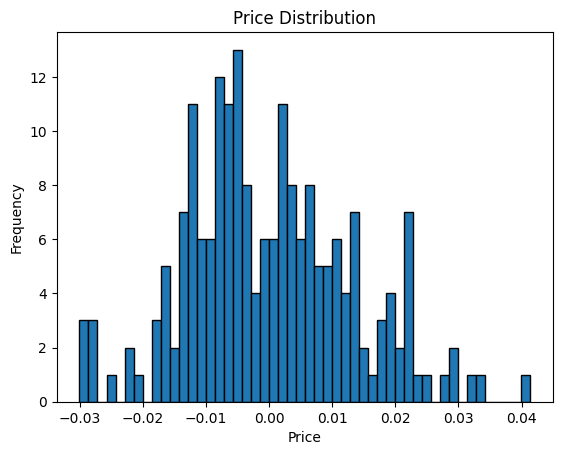

In [12]:
price_stats_df['mean'].plot(kind='hist', bins=50, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

## Category Analysis

In [13]:
category_counts.head(10)

category_id
0    20246.0
1     3391.0
2       36.0
3    12092.0
4    22233.0
5     5450.0
6      149.0
7    51214.0
8     1951.0
9     3591.0
dtype: float64

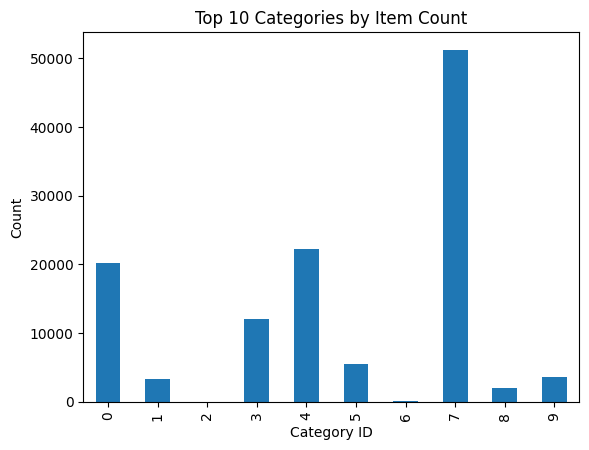

In [15]:
category_counts.head(10).plot(kind='bar')
plt.title('Top 10 Categories by Item Count')
plt.xlabel('Category ID')
plt.ylabel('Count')
plt.show()

## User Interaction Analysis

In [16]:
user_interaction_counts.head(10)

user_id
1000010    291.0
1000011      1.0
1000015    491.0
1000016     11.0
1000017      3.0
1000022      3.0
1000024      2.0
1000026     11.0
1000029      2.0
1000031     24.0
dtype: float64

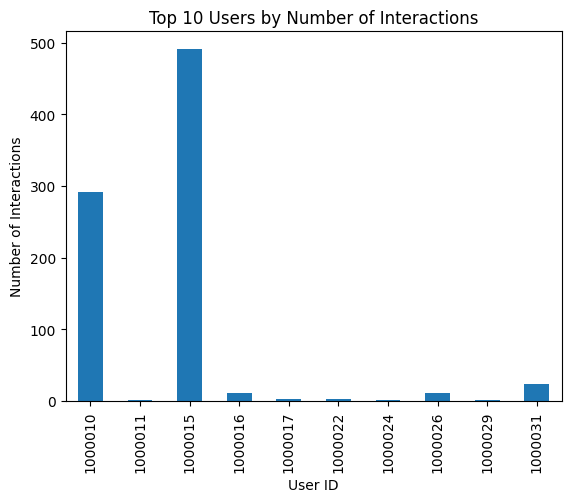

In [17]:
user_interaction_counts.head(10).plot(kind='bar')
plt.title('Top 10 Users by Number of Interactions')
plt.xlabel('User ID')
plt.ylabel('Number of Interactions')
plt.show()

## Sales Trend Analysis

In [18]:
daily_sales_df = pd.DataFrame(list(daily_sales.items()), columns=['Date', 'Sales'])
daily_sales_df = daily_sales_df.sort_values('Date')
daily_sales_df.head()

,Date,Sales
9,2023-01-15,-4300.102874
14,2023-01-16,-8119.410553
31,2023-01-17,-2760.943325
28,2023-01-18,-2926.354749
42,2023-01-19,-3634.108468


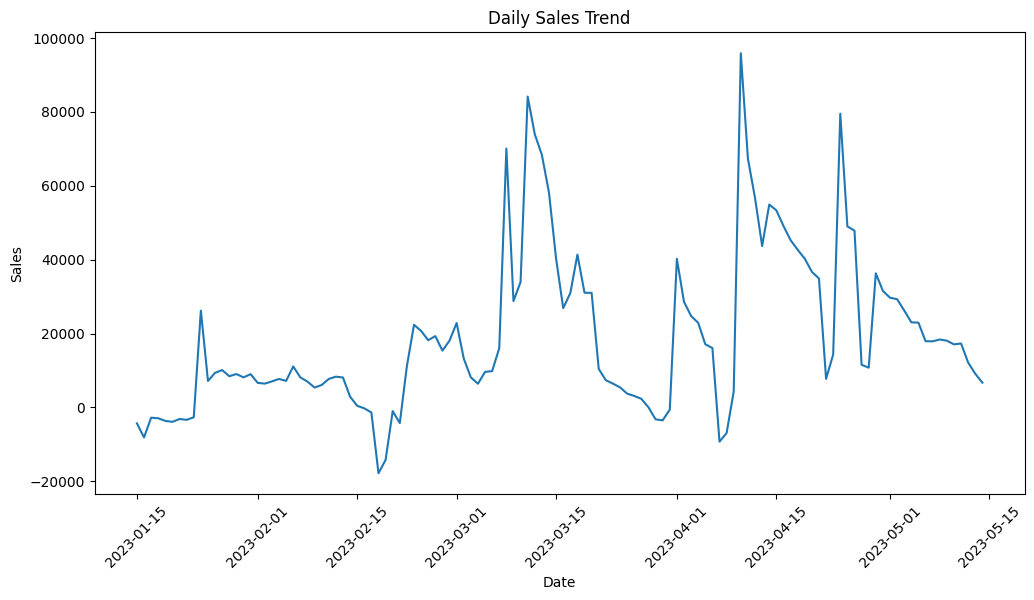

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_df['Date'], daily_sales_df['Sales'])
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

## Time-Series Analysis of Interactions

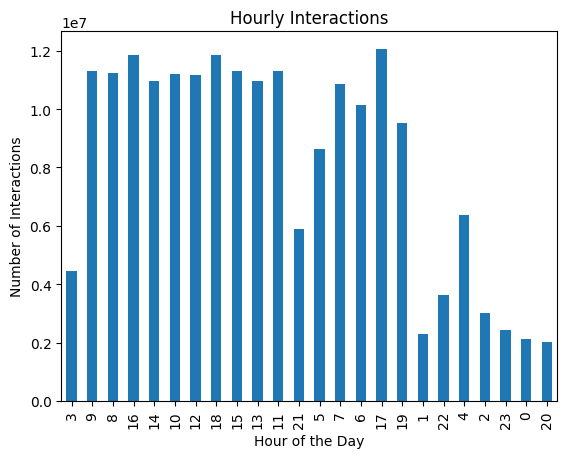

In [20]:
hourly_interactions_series = pd.Series(hourly_interactions)
hourly_interactions_series.plot(kind='bar')
plt.title('Hourly Interactions')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Interactions')
plt.show()

## Category-wise Event Distribution

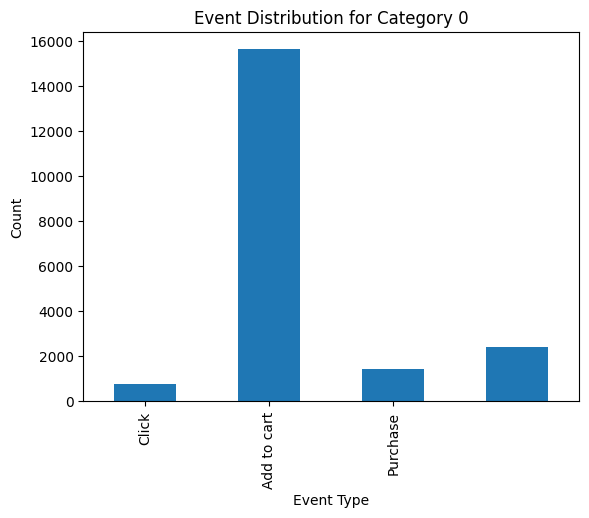

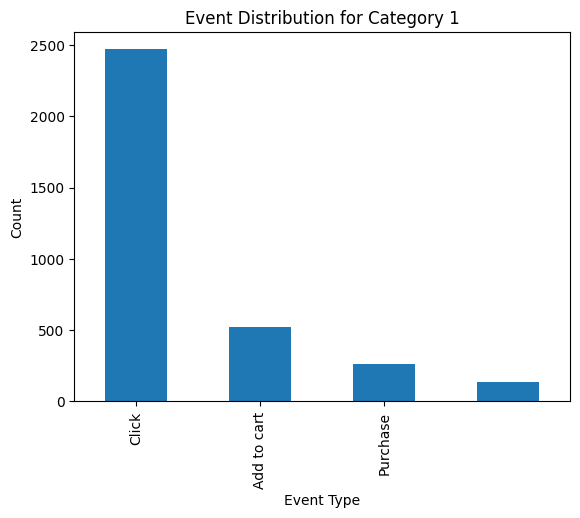

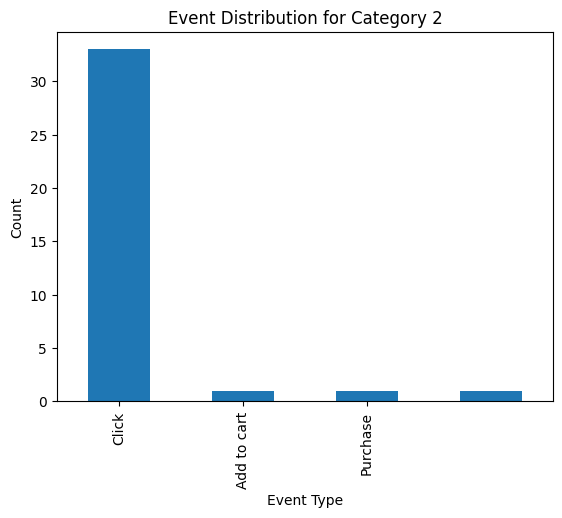

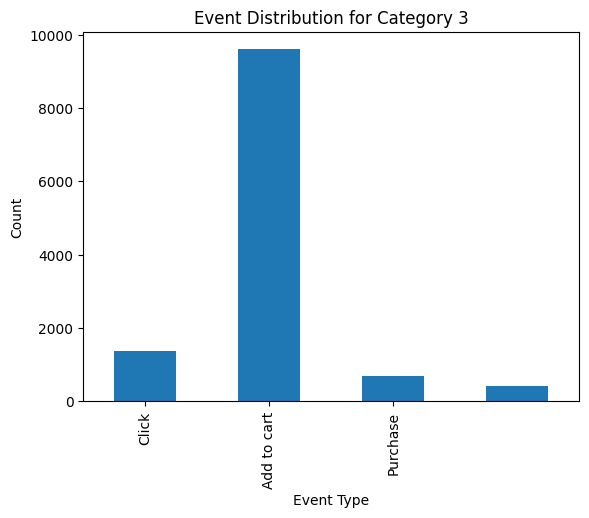

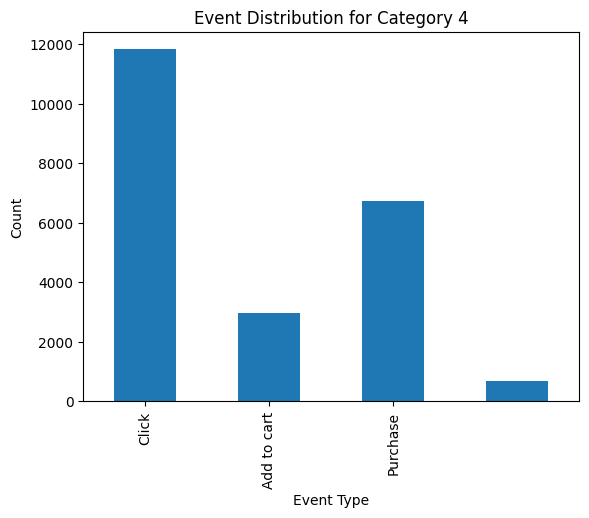

In [21]:
top_categories = category_counts.head(5).index
for category in top_categories:
    event_dist = category_event_distribution[category]
    event_dist_series = pd.Series(event_dist)
    event_dist_series.plot(kind='bar')
    plt.title(f'Event Distribution for Category {category}')
    plt.xlabel('Event Type')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1, 2], labels=['Click', 'Add to cart', 'Purchase'])
    plt.show()

## Correlation Analysis

In [23]:
# Perform correlation analysis
sample_chunk = df.sample(n=100000)

# Convert appropriate columns to numeric types
sample_chunk['event'] = pd.to_numeric(sample_chunk['event'], errors='coerce')
sample_chunk['price'] = pd.to_numeric(sample_chunk['price'], errors='coerce')

# Exclude non-numeric columns
numeric_cols = sample_chunk.select_dtypes(include=['number']).columns
correlation_matrix = sample_chunk[numeric_cols].corr()
correlation_matrix

,user_id,event,item_id,category_id,price
user_id,1.000000,0.004028,-0.002633,0.003023,-0.000499
event,0.004028,1.000000,-0.004668,0.007086,0.144593
item_id,-0.002633,-0.004668,1.000000,-0.004273,-0.003810
category_id,0.003023,0.007086,-0.004273,1.000000,-0.037891
price,-0.000499,0.144593,-0.003810,-0.037891,1.000000


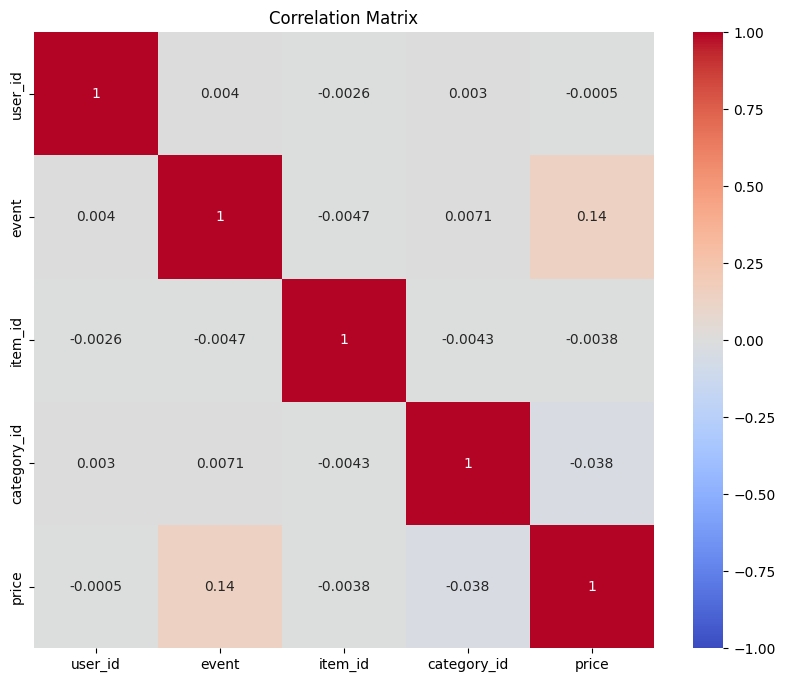

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## Summary and Insights

In this analysis, we processed a large dataset by reading it in chunks and performing various analyses on user interactions, sales trends, and more advanced analyses. Here are some key insights:

1. **Event Distribution**: We observed the distribution of different event types (clicks, add to cart, and purchases).
2. **Price Analysis**: We analyzed the price distribution of items.
3. **Category Analysis**: We identified the top categories by item count.
4. **User Interaction**: We examined the interactions of top users.
5. **Sales Trends**: We analyzed daily sales trends.
6. **Time-Series Analysis**: We explored hourly interaction patterns.
7. **Category-wise Event Distribution**: We studied the event distribution within top categories.
8. **Correlation Analysis**: We examined correlations between different attributes.

These insights can help in understanding user behavior, optimizing sales strategies, and improving the overall performance of the MegaMarket marketplace.